# Supplementary figure with more area crops

In [1]:
import dask.array as da
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patheffects as patheffects
import numpy as np
import os

import colorcet
import xarray as xr
import scipy.ndimage as ndi
from skimage.io import imread
from skimage.segmentation import watershed
import skimage.morphology as morpho
from skimage.filters import gaussian
from skimage.measure import regionprops, label

from moisan2011 import per
from pyGPA.imagetools import fftplot, gauss_homogenize2, gauss_homogenize3, trim_nans
import pyGPA.geometric_phase_analysis as GPA
import pyGPA.property_extract as pe

In [2]:
def select_large_areas(labeling, threshold=5000):
    lbl = labeling
    nlbl = np.zeros_like(lbl)
    rprops = regionprops(lbl)
    #print([prop.area for prop in rprops if prop.area > 5000])
    i = 1
    for prop in rprops:
        if prop.area > threshold:
            nlbl[lbl == prop.label] = i
            i += 1
    return nlbl

In [3]:
folder = 'data'
name = '20200713_163811_5.7um_501.2_sweep-STAGE_X-STAGE_Y_domainboundaries_stitch_v10_2020-11-20_1649_sobel_4_bw_200.tif'
NMPERPIXEL = 3.7

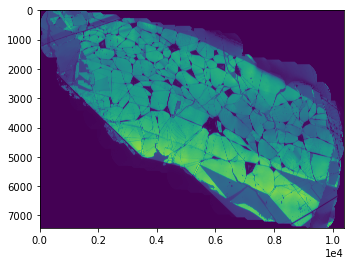

In [4]:
image = imread(os.path.join(folder, name)).squeeze()
plt.imshow(image)

In [5]:
coords = np.array([[3642.89786153, 5400.49488182],
                   [3721.72436096, 6384.55472946],
                   [3507.55425954, 8281.36876338],
                   [3380.03002363, 6921.11024705],
                   [4187.6835177, 6938.49991558],
                   [3807.04299538, 7066.02415149],
                   [4812.93836045, 7729.48655758],
                   [4099.87750689, 9225.98507689],
                   [850.69462839, 4398.48610047],
                   [363.96565178, 1325.27028875],
                   [4271.33017045, 7833.81755442],
                   [2735.31323933, 4710.03264254]])

/home/tobias/anaconda3/envs/moire-figures/lib/python3.8/site-packages/pyGPA/imagetools.py:97: RuntimeWarning: invalid value encountered in true_divide
  VV /= ndi.gaussian_filter(mask.astype(image.dtype),


(1000, 1000) 10 9 5
(1000, 1000) 6 5 4
(1000, 1000) 7 6 3
(1000, 1000) 4 3 3
(1000, 1000) 3 2 5
(1000, 1000) 10 9 2
(1000, 1000) 7 6 5
(1000, 1000) 12 11 5
(1000, 1000) 7 6 0
(1001, 1000) 11 10 0
(1000, 1000) 6 5 4
(1000, 1000) 12 11 3


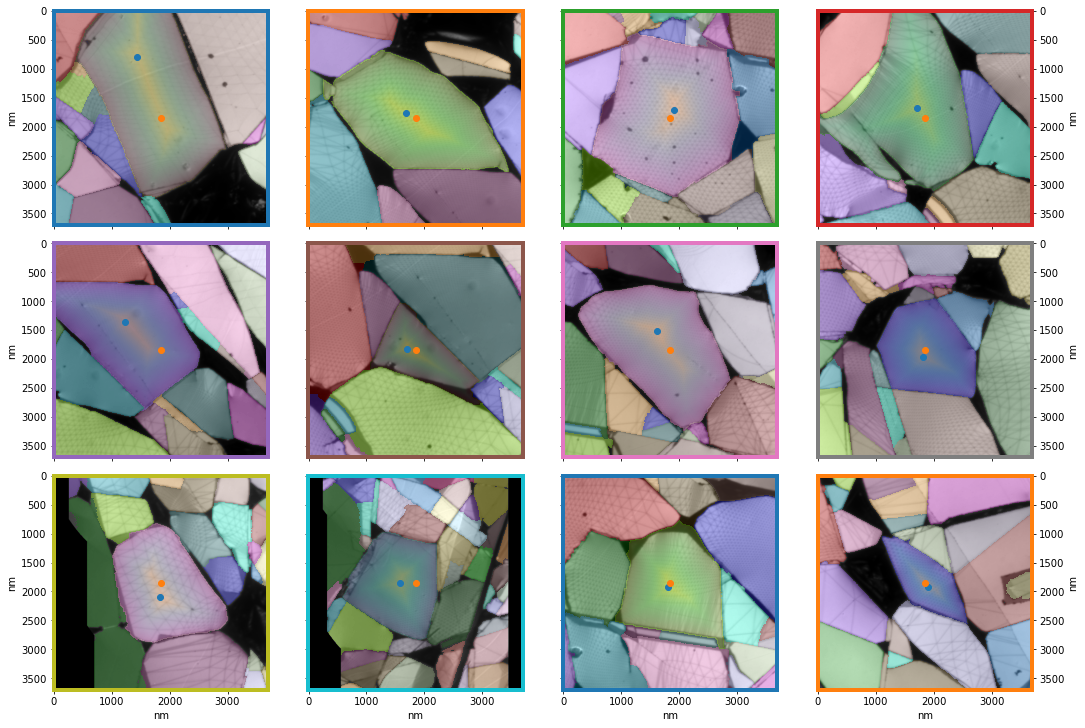

In [6]:
fig, axs = plt.subplots(3, 4, figsize=[15, 10], constrained_layout=True, sharex=True, sharey=True)
axs = axs.flat
s = 500
sprimes = []
bbox_images = []
regions = []
full_crops = []
all_dists = []
for i, coord in enumerate(coords):
    x = slice(max(int(coord[0])-s, 0), int(coord[0])+s)
    y = slice(max(int(coord[1])-s, 0), int(coord[1])+s)
    lim = image[x, y]
    if lim.shape[0] != 2*s:
        lim = np.pad(lim, ((s-lim.shape[0]//2, s-lim.shape[0]//2), (0, 0)))
    full_crops.append(lim)
    clip = np.clip(lim, *np.quantile(lim[lim > 0], [0.05, 0.9999]))
    dclip = (clip / gaussian(clip, 50)) >= 0.9
    ero = morpho.binary_erosion(dclip, selem=morpho.disk(5))
    mask2 = morpho.remove_small_holes(ero, 25**2)
    nextone = morpho.binary_erosion(gauss_homogenize3(clip, mask2,  25) > 0.91, selem=morpho.disk(8))
    labeling = label(nextone)
    llabels = select_large_areas(labeling, threshold=200)
    #labelim = np.where(llabels == 0, np.nan, llabels)
    # 1e4 is determined from histograms of images. Maybe use Otsu's methods instead?
    wres = watershed(-(gauss_homogenize3(clip, mask2,  15)), llabels, mask=clip > 1e4)
    if wres[0].max() == 0:
        region = regionprops(wres, intensity_image=lim)[wres[s, s]-2]
    else:
        region = regionprops(wres, intensity_image=lim)[wres[s, s]-1]
    regions.append(region)
    print(wres.shape, wres[s, s]+1, region.label, wres[0].max())
    dists = ndi.distance_transform_cdt(morpho.remove_small_holes(wres == wres[s, s], 25**2), metric='chessboard')
    all_dists.append(dists)
    sprimes.append(dists[s, s])
    bbox_images.append(lim[region.slice])
    coord = np.unravel_index(np.argmax(dists), dists.shape)
    axs[i].scatter(coord[0]*NMPERPIXEL, coord[1]*NMPERPIXEL)
    axs[i].scatter(s*NMPERPIXEL, s*NMPERPIXEL)

    im = axs[i].imshow(lim.T, vmax=np.quantile(lim, 0.999),
                       vmin=np.quantile(lim, 0.001), cmap='gray')
    im.set_extent(np.array(im.get_extent())*NMPERPIXEL)
    im = axs[i].imshow(
        np.where(
            wres == 0,
            np.nan,
            wres).T-0.5,
        cmap='cet_glasbey_bw_minc_20',
        interpolation='nearest',
        alpha=0.3,
        vmax=256,
        vmin=0)
    im.set_extent(np.array(im.get_extent())*NMPERPIXEL)
    im = axs[i].imshow(np.where(dists > 0, dists, np.nan).T, alpha=0.2)
    #im = axs[i].imshow(np.where(clip>clip.min()*1.2, 1, np.nan).T)
    im.set_extent(np.array(im.get_extent())*NMPERPIXEL)
    if i > 7:
        axs[i].set_xlabel('nm')
    if i % 4 == 0:
        axs[i].set_ylabel('nm')
    if i % 4 == 3:
        axs[i].yaxis.tick_right()
        axs[i].set_ylabel('nm')
        axs[i].yaxis.set_label_position("right")
        axs[i].tick_params(axis='y', which='both', labelleft=False, labelright=True)
    for axis in ['top', 'bottom', 'left', 'right']:
        axs[i].spines[axis].set_linewidth(4)
        axs[i].spines[axis].set_color(f"C{i}")
sprimes = np.array(sprimes)
#plt.savefig('crops.pdf', interpolation='none')

closest triangle: [[-0.          0.05902778]
 [ 0.06944444  0.04513889]
 [ 0.07291667  0.03472222]
 [ 0.06597222 -0.01041667]]


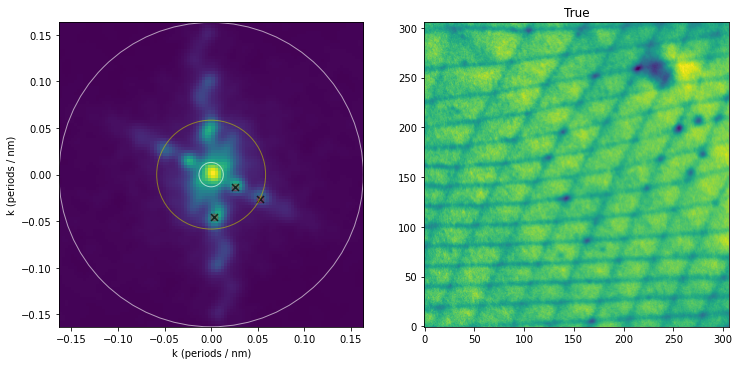

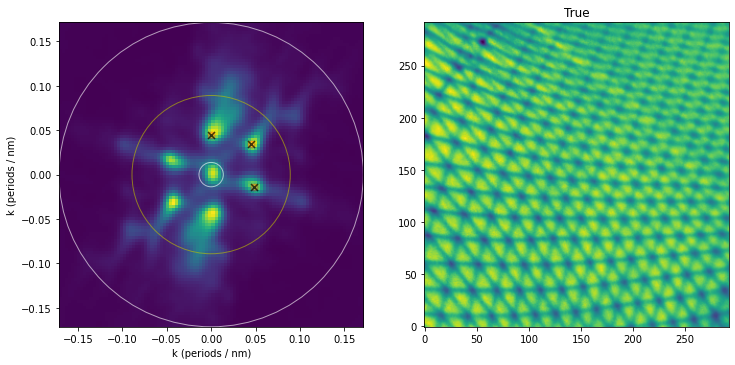

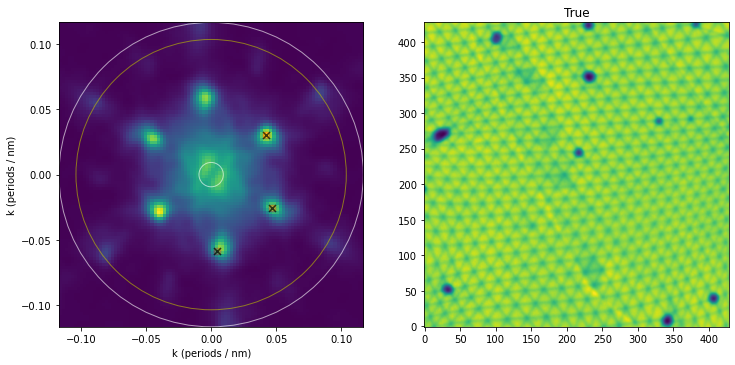

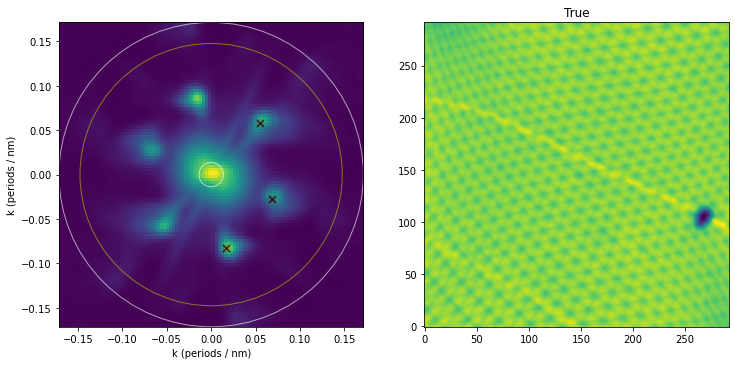

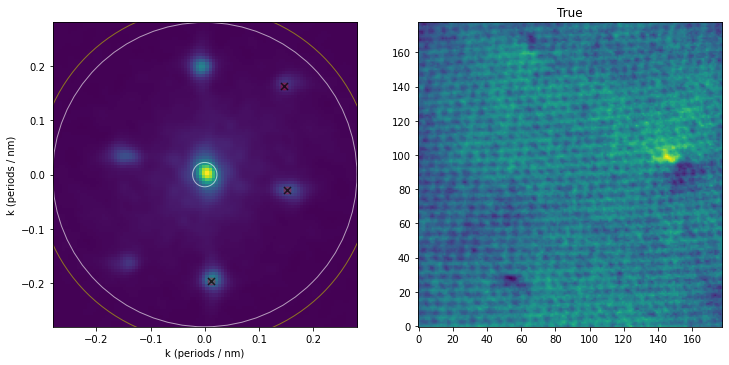

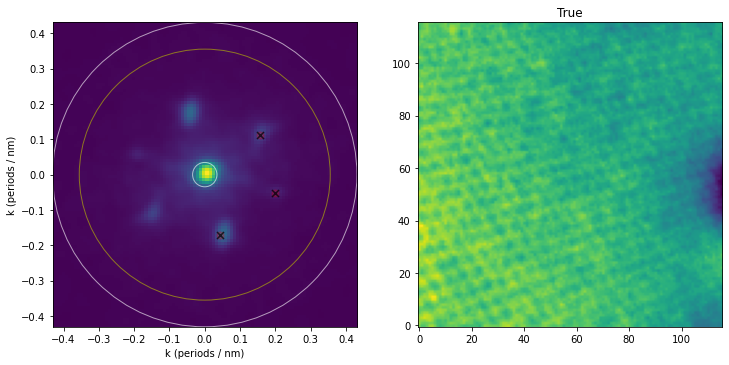

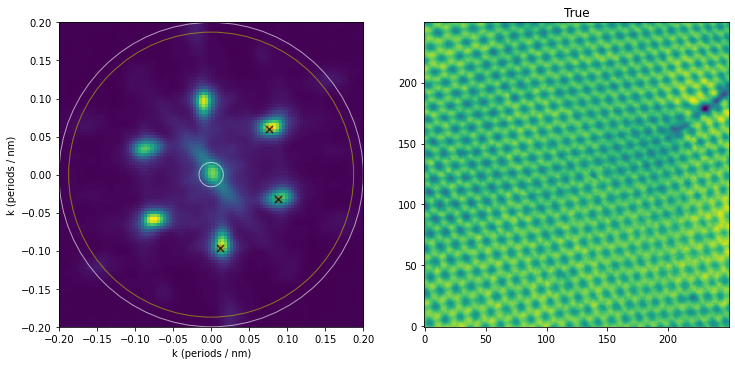

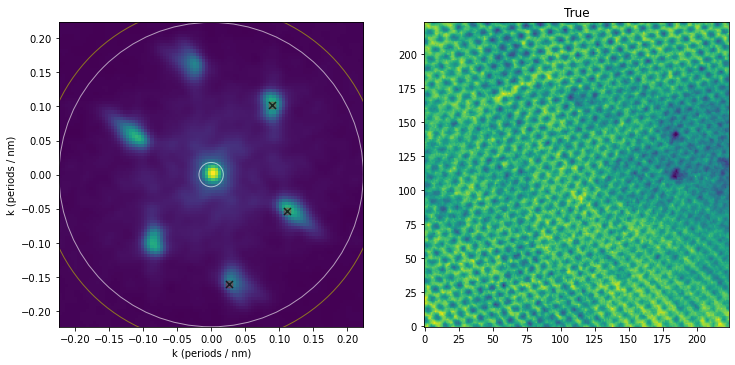

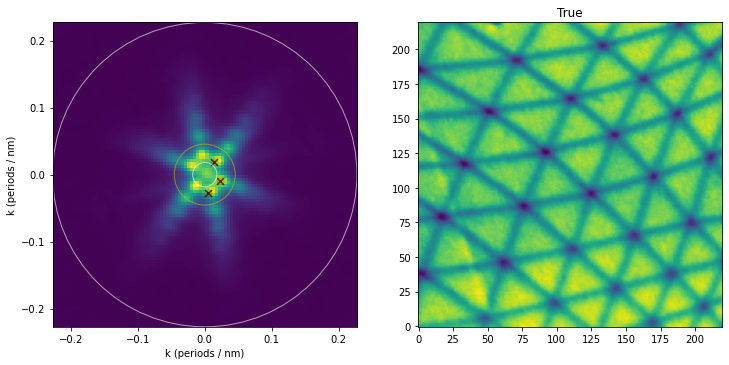

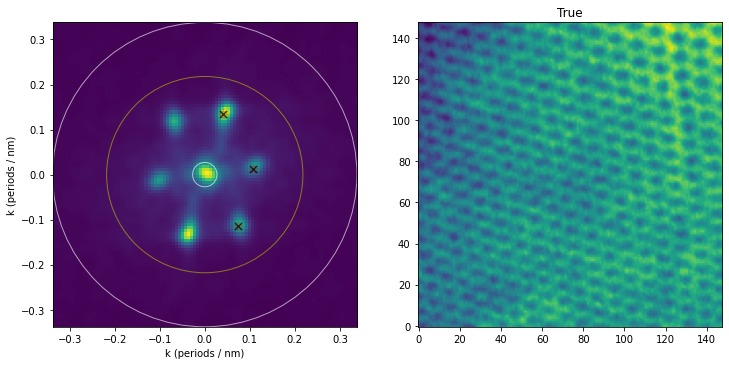

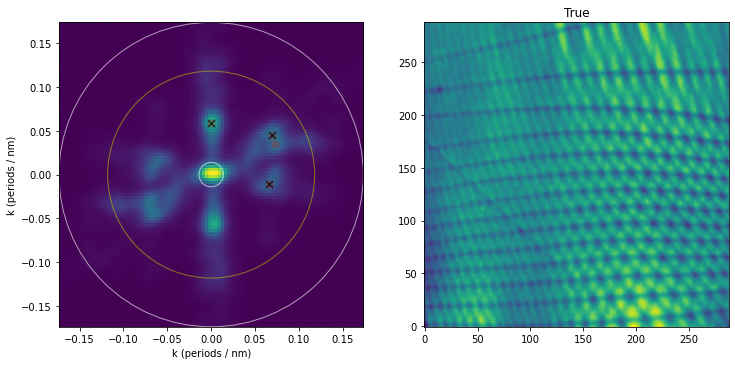

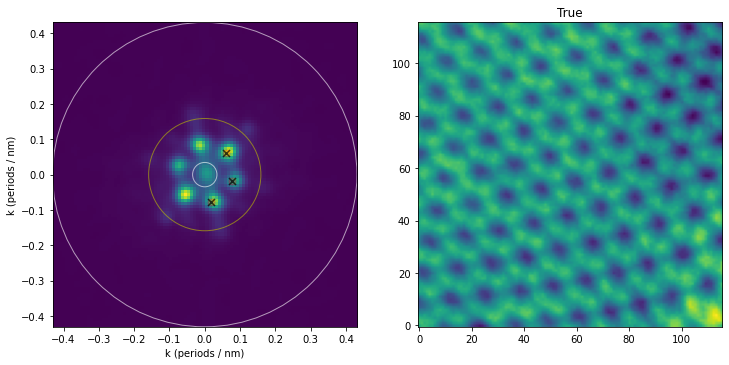

In [7]:
kvec_lists = []
d = 20

for i, coord in enumerate(coords):
    x = slice(int(coord[0])-sprimes[i]+d, int(coord[0])+sprimes[i]-d)
    y = slice(int(coord[1])-sprimes[i]+d, int(coord[1])+sprimes[i]-d)
    lim = image[x, y].astype(np.float64)
    pks, _ = GPA.extract_primary_ks(gauss_homogenize2(lim, np.ones_like(lim), 50),
                                    pix_norm_range=(4, 50), plot=True, threshold=0.7, sigma=1.5)
    if i == 0:
        pks[2] = pks[0]-pks[1]
    kvec_lists.append(pks)
all_props = np.array([pe.Kerelsky_plus(pks, nmperpixel=NMPERPIXEL, sort=1) for pks in kvec_lists])
thetas = all_props[:, 0]

In [8]:
thetas

array([0.122391  , 0.16404771, 0.17986711, 0.2605118 , 0.61616345,
       0.62834189, 0.31575084, 0.45981773, 0.08142904, 0.42232177,
       0.22391519, 0.26834259])

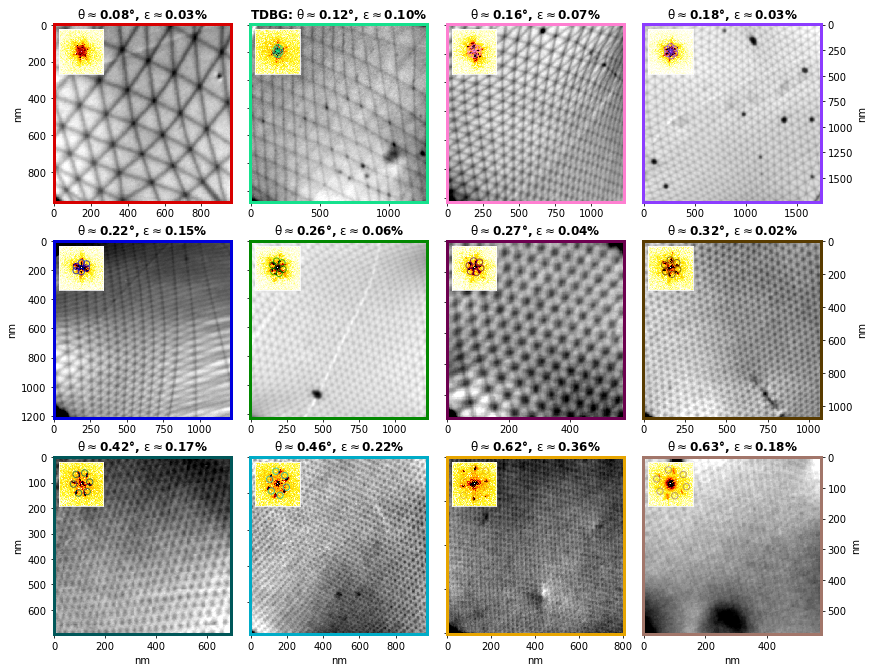

In [9]:


glasbey = plt.get_cmap('cet_glasbey_dark')(np.linspace(0, 1, 255))

fig, axs = plt.subplots(3, 4, figsize=[12, 9.2], constrained_layout=True)
axs = axs.flat
sindices = np.argsort(thetas)
sdp = sprimes[sindices]
coordsl = coords[sindices]
colors = [0, 9, 5, 1,
          10, 2, 6, 7,
          8, 3, 4, 11]
rf = 0.08

for i, coord in enumerate(coordsl):
    x = slice(int(coord[0])-sdp[i], int(coord[0])+sdp[i])
    y = slice(int(coord[1])-sdp[i], int(coord[1])+sdp[i])
    lim = image[x, y]
    pks = kvec_lists[sindices[i]]
    props = pe.Kerelsky_plus(pks, nmperpixel=NMPERPIXEL, sort=1)
    p, _ = per(lim-lim.mean(), inverse_dft=False)
    fftim = np.abs(np.fft.fftshift(p))
    axin = inset_axes(axs[i], width="25%", height="25%", loc=2)
    axin.tick_params(labelleft=False, labelbottom=False, direction='in', length=0)
    for axis in ['top', 'bottom', 'left', 'right']:
        axin.spines[axis].set_color(f"white")

    fftplot(fftim, ax=axin, pcolormesh=False, vmax=np.quantile(fftim, 0.995),
            vmin=np.quantile(fftim, 0.01), cmap='cet_fire_r', d=NMPERPIXEL, interpolation='none')
    axin.scatter(*(pks/NMPERPIXEL).T + 1/NMPERPIXEL/sdp[i],
                 edgecolor=glasbey[colors[i]], alpha=0.7, s=40, marker='o', color='none')
    axin.scatter(*(-pks/NMPERPIXEL).T + 1/NMPERPIXEL/sdp[i],
                 edgecolor=glasbey[colors[i]], alpha=0.7, s=40, marker='o', color='none')

    axin.set_xlim([-rf, rf])
    axin.set_ylim([-rf, rf])
    axs[i].set_title(f"$\\theta \\approx ${props[0]:.2f}°, $\\epsilon \\approx ${props[2]*100:.2f}%", weight='bold')

    im = axs[i].imshow(lim,  # [d:-d,d:-d],
                       #vmax=3.8e4,#
                       vmax=np.quantile(lim[d:-d, d:-d], 0.9999),
                       #vmin= 1.5e4, #
                       vmin=np.quantile(lim[d:-d, d:-d], 0.00001),
                       interpolation='none',
                       cmap='gray')
    im.set_extent(np.array(im.get_extent())*NMPERPIXEL)

    if i > 7:
        axs[i].set_xlabel('nm')
    if i % 4 == 0:
        axs[i].set_ylabel('nm')
    elif i % 4 == 3:
        axs[i].yaxis.tick_right()
        axs[i].set_ylabel('nm')
        axs[i].yaxis.set_label_position("right")
        axs[i].tick_params(axis='y', which='both', labelleft=False, labelright=True)
    else:
        axs[i].tick_params(axis='y', which='both', labelleft=False, labelright=False)
    for axis in ['top', 'bottom', 'left', 'right']:
        axs[i].spines[axis].set_linewidth(3)
        axs[i].spines[axis].set_color(glasbey[colors[i]])
    if i == 1:
        axs[i].set_title(f"TDBG: " + axs[i].get_title(), weight='bold')
fig.set_constrained_layout_pads(w_pad=2./72., h_pad=2./72.,
                                hspace=0., wspace=-0.15)
plt.savefig(os.path.join('figures', 'Scrops.pdf'))

/tmp/ipykernel_18569/4218892267.py:30: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "interpolation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(os.path.join('figures', 'Scropsloc.pdf'), interpolation='none')


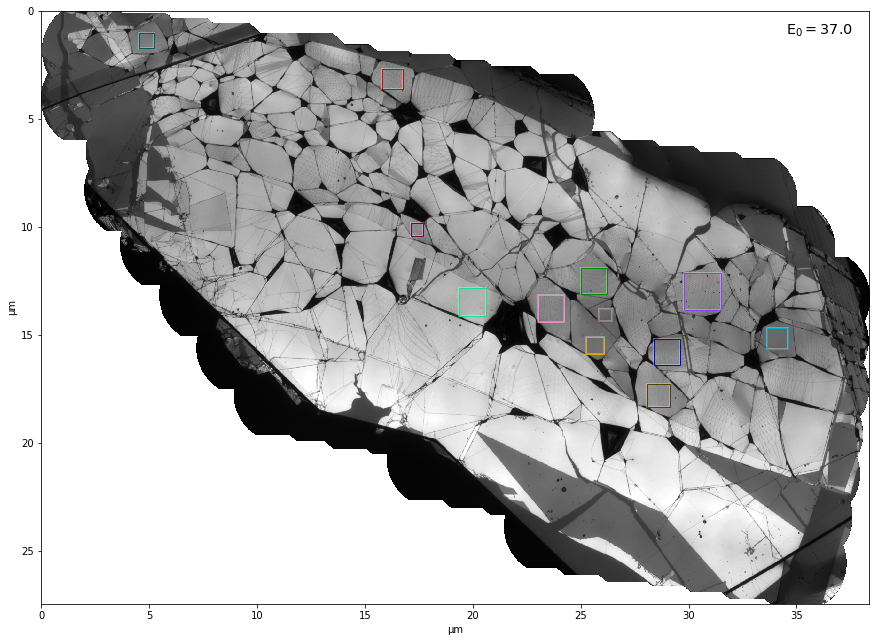

In [10]:
fig, ax = plt.subplots(figsize=[12, 9])
z = 4
zim = da.coarsen(np.mean, da.from_array(image), {1: z, 0: z}, trim_excess=True).compute()
im = ax.imshow(np.where(zim == 0, np.nan, zim), cmap='gray',
               vmin=np.nanquantile(zim, 0.1), vmax=np.nanquantile(zim, 0.999))
im.set_extent(np.array(im.get_extent())*z)

image = imread(os.path.join(folder, name)).squeeze()
zim = da.coarsen(np.mean, da.from_array(image), {1: z, 0: z}, trim_excess=True).compute()
im = ax.imshow(trim_nans(np.where(zim == 0, np.nan, zim)), cmap='gray',
               vmin=np.nanquantile(zim, 0.1), vmax=np.nanquantile(zim, 0.999),
               interpolation='none')
im.set_extent(np.array(im.get_extent())*z*NMPERPIXEL/1e3)
#ax.set_title(f"$E_0 = ${37.:.1f}")
ax.set_xlabel('μm')
ax.set_ylabel('μm')
ax.patch.set_alpha(0.5)
for i, coord in enumerate(coordsl):
    circle = plt.Rectangle(coord[[1, 0]]*NMPERPIXEL/1e3-sdp[i]*NMPERPIXEL/1e3,
                           2*sdp[i]*NMPERPIXEL/1e3, 2*sdp[i]*NMPERPIXEL/1e3,
                           edgecolor=glasbey[colors[i]], fill=False, alpha=0.99, lw=1,
                           path_effects=[patheffects.withStroke(linewidth=2, foreground="white", alpha=0.3)])
    ax.add_artist(circle)
ax.text(0.98, 0.98, f"$E_0 = ${37.:.1f}",
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize='x-large')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join('figures', 'Scropsloc.pdf'), interpolation='none')

In [11]:
biname = '20200508_132700_0.66um_461.5_drizzle_data.nc'

bidata = xr.open_dataset(os.path.join(folder, biname), chunks='auto')
bidata.Intensity.data
mean = bidata.Intensity.mean(axis=0).compute()
meancrop = mean[340:340+256, 540:540+256].data
meancrop2 = mean[680:680+256, 260:260+256].data
biNMPERPIXEL = 0.88

closest triangle: [[ 0.08984375 -0.03125   ]
 [ 0.0703125   0.05859375]
 [ 0.05078125 -0.03125   ]
 [ 0.0625      0.015625  ]
 [ 0.06640625  0.00390625]
 [ 0.06640625 -0.01171875]
 [ 0.08203125 -0.0078125 ]
 [-0.          0.0703125 ]
 [ 0.03125     0.0546875 ]
 [ 0.06640625  0.02734375]
 [ 0.0625      0.0390625 ]
 [ 0.046875    0.046875  ]
 [ 0.078125    0.03125   ]
 [ 0.0859375   0.01171875]
 [ 0.15625     0.02734375]
 [ 0.046875   -0.05078125]
 [ 0.01171875  0.0625    ]
 [ 0.05078125  0.0703125 ]
 [-0.          0.08984375]
 [ 0.01953125 -0.08984375]
 [ 0.09375     0.0234375 ]
 [ 0.04296875  0.078125  ]
 [ 0.00390625 -0.1015625 ]
 [-0.          0.109375  ]
 [ 0.0390625   0.09375   ]
 [ 0.0234375   0.08203125]
 [ 0.0234375  -0.07421875]
 [ 0.0625      0.13671875]
 [ 0.1015625   0.0234375 ]
 [-0.          0.1328125 ]
 [ 0.140625   -0.03125   ]
 [ 0.1171875   0.01953125]
 [ 0.05859375  0.09375   ]]
closest triangle: [[ 0.07421875  0.01171875]
 [ 0.0234375   0.06640625]
 [ 0.05078125 -0.0

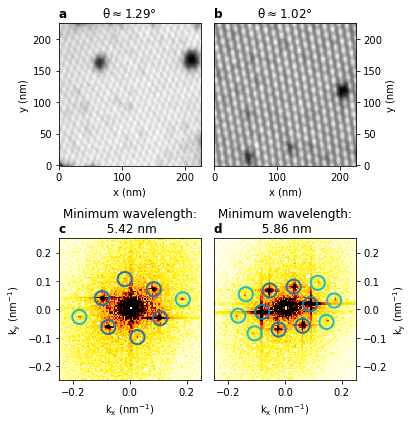

In [12]:
rf = 0.25
fig, axs = plt.subplots(figsize=[6, 6], ncols=2, nrows=2,
                        sharex='row', sharey='row')
p, _ = per(meancrop-meancrop.mean(), inverse_dft=False)
pks, _ = GPA.extract_primary_ks(meancrop, pix_norm_range=(15, 100), threshold=0.001, sigma=0.8)
pks = pks / biNMPERPIXEL
fftim = np.abs(np.fft.fftshift(p))
im = axs[0, 0].imshow(meancrop.T, cmap='gray', origin='lower', interpolation='none')
im.set_extent(np.array(im.get_extent())*biNMPERPIXEL)
im = axs[0, 1].imshow(meancrop2.T, cmap='gray', origin='lower', interpolation='none')
im.set_extent(np.array(im.get_extent()) * biNMPERPIXEL)
fftkwargs = dict(cmap='cet_fire_r', d=biNMPERPIXEL,
                 interpolation='none',
                 pcolormesh=False, origin='lower')
fftplot(fftim, ax=axs[1, 0],
        vmax=np.quantile(fftim, 0.995),
        vmin=np.quantile(fftim, 0.01),
        **fftkwargs)

scatterkwargs = dict(marker='o', facecolor='none', s=200, linewidth=2)
axs[1, 0].scatter(*np.concatenate([pks, -pks]).T + 1/biNMPERPIXEL/256,
                  edgecolor='C0', **scatterkwargs)
extra_ks = np.array([pks[0]+pks[1]])
axs[1, 0].set_title(f"Minimum wavelength:\n {1/np.linalg.norm(extra_ks, axis=1).max():.2f} nm")
axs[1, 0].scatter(*np.concatenate([extra_ks, -extra_ks]).T + 1/biNMPERPIXEL/256,
                  marker='o', facecolor='none',
                  edgecolor='tab:cyan',
                  s=200, linewidth=2)


p, _ = per(meancrop2-meancrop2.mean(), inverse_dft=False)
pks2, _ = GPA.extract_primary_ks(meancrop2, pix_norm_range=(15, 100), threshold=0.001, sigma=0.8)
pks2 = pks2 / biNMPERPIXEL
fftim = np.abs(np.fft.fftshift(p))
fftplot(fftim, ax=axs[1, 1],
        vmax=np.quantile(fftim, 0.995),
        vmin=np.quantile(fftim, 0.01), **fftkwargs)
axs[1, 1].scatter(*np.concatenate([pks2, -pks2]).T + 1/biNMPERPIXEL/256,
                  edgecolor='C0',
                  **scatterkwargs)
extra_ks = np.array(pks2[0] + pks2)
axs[1, 1].set_title(f"Minimum wavelength:\n {1/np.linalg.norm(extra_ks, axis=1).max():.2f} nm")
print(f'zeroth order wavelength: {1/np.linalg.norm(pks, axis=1).max():.2f} ')
print(f'zeroth order wavelength: {1/np.linalg.norm(pks2, axis=1).max():.2f} ')
axs[1, 1].scatter(*np.concatenate([extra_ks, -extra_ks]).T + 1/biNMPERPIXEL/256,
                  edgecolor='tab:cyan',
                  **scatterkwargs)

axs[0, 0].set_title(f"$\\theta \\approx ${GPA.f2angle(np.linalg.norm(pks, axis=1).mean()):.2f}°")
axs[0, 1].set_title(f"$\\theta \\approx ${GPA.f2angle(np.linalg.norm(pks2, axis=1).mean()):.2f}°")
for i in range(2):
    axs[0, i].set_ylabel('y (nm)')
    axs[0, i].set_xlabel('x (nm)')
    axs[1, i].set_xlim([-rf, rf])
    axs[1, i].set_ylim([-rf, rf])
    axs[1, i].set_ylabel('k$_y$ (nm$^{-1}$)')
    axs[1, i].set_xlabel('k$_x$ (nm$^{-1}$)')

for ax, label in zip(axs.flat, 'abcd'):
    ax.set_title(label, loc='left', fontweight='bold')
for ax in axs[:, 1]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.tick_params(axis='y', which='both', labelleft=False, labelright=True)
plt.tight_layout(w_pad=0)
plt.savefig(os.path.join('figures', 'SIresolution.pdf'))